In [1]:
#Downloading and formatting the dataset

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = dt.datetime.now()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers = symbols_list, start = start_date, end = end_date)
df = df.stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed


In [2]:
#Computing the technical indicators

df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open'])) ** 2)
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))

df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,1]) 
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20)
    if macd is not None:
        return macd.iloc[:, 0].sub(macd.iloc[:, 0].mean()).div(macd.iloc[:, 0].std())
    else:
        return pd.Series([np.nan] * len(close), index=close.index)

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6

In [3]:
#Aggregate to monthly level and filter top 150 most liquid stocks for each month
'''This is done to reduce training time for the ML model and experiment with strats'''
#This computes the average monthly dollar volume to give a sense of liquidity

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                          'open','high','low','close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack().to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()

In [4]:
#Calculating the 5 year rolling average rolling average for each stock
#and use this value to filter out top 150 most liquid stocks for each month

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending = False)

#We are finding the 150 most liquid stocks then dropping the columns that we dont need
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis = 1)

In [5]:
'''Removing the timezones from the dataframe data as they are not necessary'''
#Remove the time zone from the 'date' index of data
data.index = data.index.set_levels([data.index.levels[0].tz_localize(None), data.index.levels[1]])

#Convert the 'date' index to only the date part (remove time part)
data.index = data.index.set_levels([data.index.levels[0].date, data.index.levels[1]])

In [6]:
#Calculating monthly returns for different time horizons as features
'''To capture time series dynamics that reflect, for instance, momentum patterns, we
compute historical returns using the method .pct_change(lag), that is, returns over
various monthly periods as identified by lags'''

def calculate_returns(df):

    outlier_cutoff = 0.005 #only the 99.005 percentile is considered and values above this percentile are assigned the same value as the cutoff
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                    upper = x.quantile(1 - outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df
    
data = data.groupby(level = 1, group_keys = False).apply(calculate_returns).dropna()

In [7]:
'''Download FAMA-FRENCH factors and calculate rolling factor betas'''
#we are introducing the FAMA french data to estimate the exposure of assets to
#common risk factors with linear regression.
#five factors are market risk size, value, operating probability and investment
#these have been shown to empirically assess asset returns
#we can access historical returns using pandas-datareader and estimate historial 
#exposures using Rollingols model

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start = '2010')[0].drop('RF', axis = 1)

factor_data.index = factor_data.index.to_timestamp() #but this returns beginning of month data, which we have to fix to end of month

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'
#now we just combine this with the 1 month return from previous code

# '''We are adding timezones to factordata date as data has timezones'''
# #Check if 'factor_data' is timezone-aware
# if factor_data.index.tz is None:
#     # If it's not timezone-aware, localize it to UTC (or any timezone you prefer)
#     factor_data.index = factor_data.index.tz_localize('UTC')
# else:
#     # If it's already timezone-aware, ensure it's in the same timezone (UTC)
#     factor_data.index = factor_data.index.tz_convert('UTC')
# '''end of bug fix'''

factor_data = factor_data.join(data['return_1m']).sort_index()

In [8]:
'''Filter out stocks with less than 10 months of data'''
#we do this because we are going to use rolling window for the regression of 24mnths
#stocks without enough data can break our functions

observations = factor_data.groupby(level = 1).size()
valid_stocks = observations[observations >= 10] #more than 10 months data

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [9]:
'''Calculating the rolling factor betas'''

betas = (factor_data.groupby(level = 1,
                    group_keys = False)
        .apply(lambda x: RollingOLS(endog = x['return_1m'],
                                    exog = sm.add_constant(x.drop('return_1m', axis = 1)),
                                    window = min(24, x.shape[0]), #if less than 24 months data, still calculate ols
                                    min_nobs = len(x.columns)+1)
        .fit(params_only = True)
        .params
        .drop('const', axis = 1)))

In [10]:
'''Joining the betas to the features as well'''
#however we cannot blindly join betas to our dataset
#this is because we use the factor at the beginning of the month and return at the end of the month to compute betas.
#so at the end of the month, well be able to run the regression and have the betas but we will have them in the next month.
#so the betas of oct 31 will be known in nov 1
#so we shift the betas one month ahead before joining
#doing betas.shift() will simply shift betas forward by ticker, so XOM will get WMT's beta

data = data.join( betas.groupby('ticker').shift() )

#removing the NaN values in the FAMA-French columns
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis = 1)

In [11]:
'''Now we will start with the ML model as the data is complete'''
#We have the top 150 most liquid stocks at the end of each month.
#Our job is to build portfolios at the EOM and evaluate which stocks to put in.

'''We'll use a K-means clustering alg to group similar assets based on their features'''
#Split the stocks into four diff groups (optimal number of clusters as said by a quant)

"We'll use a K-means clustering alg to group similar assets based on their features"

In [12]:
from sklearn.cluster import KMeans

#Now we'll assign a cluster to each stock
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4, #4 clusters: 0,1,2,3
                           random_state = 0,  #clustering works with random seed
                           init = 'random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

In [13]:
'''Visualizing the clustering'''
#Since we didnt normalize the RSI before, we can use this for visualization
#We cannot visualize all the features in even a 3 dimensional space

def plot_clusters(data):

    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    #5th index (6th column) is the ATR in the dataframe
    #1st index (2nd column) is the RSI in the dataframe
    #Plotting ATR against RSI
    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color = 'red', label = 'cluster_0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color = 'green', label = 'cluster_1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color = 'blue', label = 'cluster_2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color = 'black', label = 'cluster_3')

    plt.legend()
    plt.show()

In [ ]:
#actually plotting

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

#an observation i made was that the clusters are grouped based on RSI values
#clusters more or less are grouped as >60, 50-60, 40-50 and <40
#however since K-means centroids are random, the clusters are also a bit random

In [14]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18)) #checked the k means docs for this. 18 represents the number of columns of data

initial_centroids[:, 1] = target_rsi_values #rsi value column

In [15]:
'''Now we are going to apply the newfound knowledge about initial centroids to the K-means clustering alg'''
#We will drop the original clusters

data = data.drop('cluster', axis = 1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4, #4 clusters: 0,1,2,3
                           random_state = 0,  #clustering works with initial centroids
                           init = initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [16]:
'''At the beginnng of each new month, select stocks based on cluster and form'''
'''a portfolio based on efficient frointier max sharpe ratio optimization'''
#momentum is persistent, and our idea would be that stocks clustered around 70 rsi centroid should
#continue to outperform in the following month, So we would select the stocks of cluster 3

filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level = 1)
filtered_df.index = filtered_df.index + pd.DateOffset(1) #moving each day with one so we go from end of month to beginning of next month
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()

In [35]:
'''DEFINE PORTFOLIO OPTIMIZATION FUNCTION'''
#we will use the PyPortfolioOpt package and EfficientFrontier to maximize the sharpe ratio
#to optimize the weights of a given portfolio, we would need to supply last one year prices to the function
#apply single stock weight bounds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio)

'DEFINE PORTFOLIO OPTIMIZATION FUNCTION'

In [17]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

#the lower bound is here because if i just put in 0, the porfolio might be designed such that:
#1 stock has a weight of 1 and the others have a weight of 0

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices = prices,
                                                      frequency = 252) #1 yr of trading data
    cov = risk_models.sample_cov(prices = prices,
                                 frequency = 252)
    ef = EfficientFrontier(expected_returns = returns,
                           cov_matrix = cov,
                           weight_bounds = (lower_bound, .1),
                           solver = 'SCS')
    weights = ef.max_sharpe()

    return ef.clean_weights()

In [18]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers = stocks,
                     start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end = data.index.get_level_values('date').unique()[-1]) #past year of data collected

[*********************100%***********************]  152 of 152 completed


In [39]:
#Calculate daily returns for each stock whcih could land up in the portfolio
#Loop over each month start, select stocks for the month and calculate weights for the nextmonth
#if max sharpe ratio optimization fails for a monnth, apply equally weighted weights
#calculate each day portfolio return

In [19]:
retruns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()


for start_date in fixed_dates.keys():

    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date] #stocks for each month which will form the portfolio

    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    #weights = optimize_weights(prices = optimization_df,
    #                       lower_bound = round(1/(len(optimization_df.columns*2)),3)) #half of the weight of an equally weighted portfolio

In [100]:
optimization_start_date = (pd.to_datetime( min(fixed_dates.keys()) ) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
optimization_end_date = (pd.to_datetime( max(fixed_dates.keys()) ) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

In [101]:
#now creating an optimization dataframe to calculate the weights of the stocks in the portfolio

optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][fixed_dates[dates[-1].strftime('%Y-%m-%d')]] #latest date (1 day more than optimization end date) that is in the dict fixed_dates

In [103]:
weights = optimize_weights(prices = optimization_df,
                           lower_bound = round(1/(len(optimization_df.columns*2)),3)) #half of the weight of an equally weighted portfolio

weights = pd.DataFrame(weights, index = pd.Series(0))

In [291]:
#implementing the weights back into the original loop:

retruns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()


for start_date in fixed_dates.keys():

    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date] #stocks for each month which will form the portfolio

    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][cols]
    success = False

    try:
        weights = optimize_weights(prices = optimization_df,
                            lower_bound = round(1/(len(optimization_df.columns*2)),3)) #half of the weight of an equally weighted portfolio

        weights = pd.DataFrame(weights, index = pd.Series(0))

        success = True
    except:
        print(f"Max sharpe optimization failed for {start_date}, Continuing with equal weights")

    if not success:
        weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                               index=optimization_df.columns.tolist(),
                               columns=pd.Series(0)).T

    temp_df = retruns_dataframe[start_date:end_date]

    temp_df = temp_df.stack().to_frame('return').reset_index(level = 0)\
                    .merge( weights.stack().to_frame('weight').reset_index(level = 0, drop = True),
                    left_index = True,
                    right_index = True )\
                    .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

    temp_df.index.names = ['date', 'ticker']
    temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

    temp_df = temp_df.groupby(level = 0)['weighted_return'].sum().to_frame('Strategy Return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)

portfolio_df = portfolio_df.drop_duplicates()

Max sharpe optimization failed for 2019-01-01, Continuing with equal weights
Max sharpe optimization failed for 2019-02-01, Continuing with equal weights
Max sharpe optimization failed for 2019-05-01, Continuing with equal weights
Max sharpe optimization failed for 2019-06-01, Continuing with equal weights
Max sharpe optimization failed for 2019-07-01, Continuing with equal weights
Max sharpe optimization failed for 2019-10-01, Continuing with equal weights
Max sharpe optimization failed for 2019-12-01, Continuing with equal weights
Max sharpe optimization failed for 2020-01-01, Continuing with equal weights
Max sharpe optimization failed for 2020-03-01, Continuing with equal weights
Max sharpe optimization failed for 2020-04-01, Continuing with equal weights
Max sharpe optimization failed for 2020-06-01, Continuing with equal weights
Max sharpe optimization failed for 2020-07-01, Continuing with equal weights
Max sharpe optimization failed for 2021-02-01, Continuing with equal weights

KeyError: 'return'

<Axes: xlabel='date'>

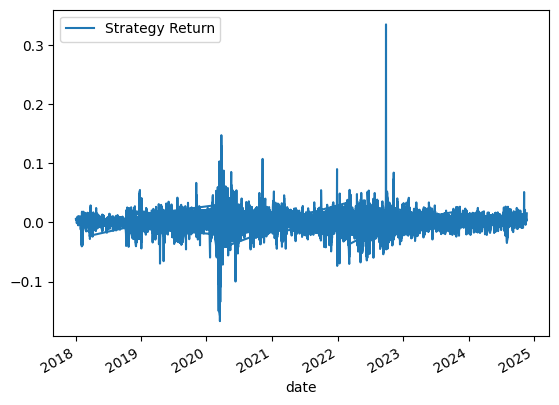

In [279]:
portfolio_df.plot()

In [280]:
'''Visualize portfolio returns and compare to beta/S&P500 returns'''
#first we download the SPY ETF data, then build an object that calculates the log retuns of the SPY

end_date = dt.datetime.now()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

spy = yf.download(tickers = 'SPY',
                  start = start_date,
                  end = end_date)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold', 'Date': 'date'}, axis = 1)
spy_ret.columns = ['SPY Buy&Hold'] #to make consistent with the portfolio_df

[*********************100%***********************]  1 of 1 completed


In [281]:
#Now, we merge the portfolio returns into the spy returns

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

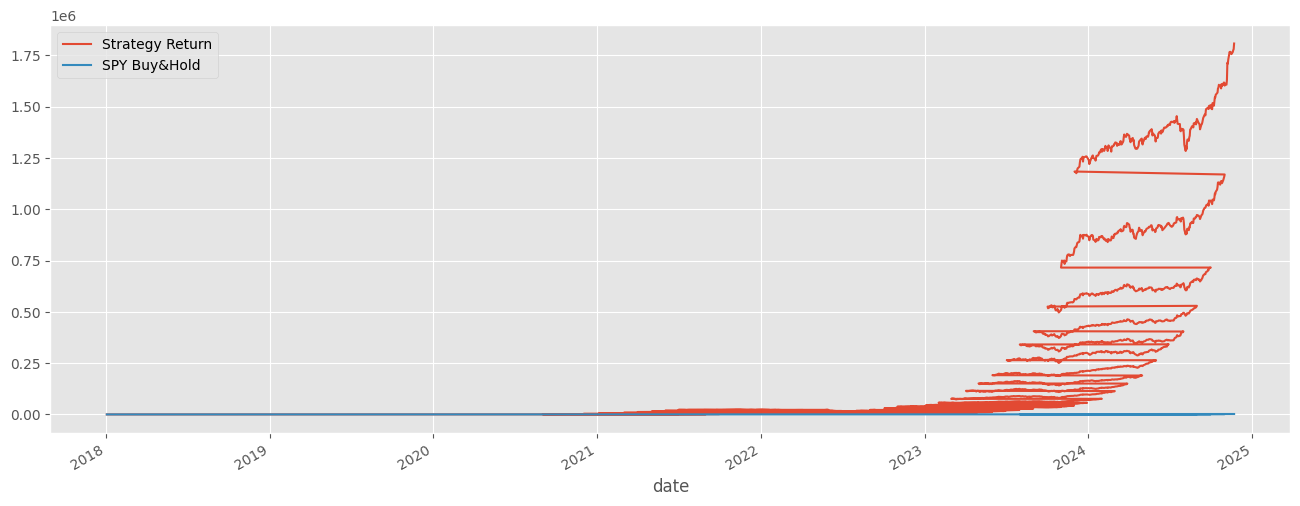

In [290]:
plt.style.use('ggplot')

portfolio_cumilative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
portfolio_cumilative_return.plot(figsize=(16,6))

plt.show()